In [1]:
import glob
from hera_qm import xrfi as xrfi
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
import numpy.ma as ma
import os
import itertools as it
from pyuvdata import UVData
import sys
import json
np.set_printoptions(threshold='nan')


In [20]:
Data_Path='/lustre/aoc/projects/hera/djacobs/IDR2_flags/2458140'
#This will take in a data path and output the arrays needed to plot the flags.
#init variables
file_flag_xx=[]
file_flag_yy=[]
time_mean_xx=[]
time_mean_yy=[]
time_mean_xx_old=[]
time_mean_yy_old=[]
flag_times_xx=[]
flag_times_yy=[]
chan_mean_xx=[]
chan_mean_yy=[]
chan_mean_xx_old=[]
chan_mean_yy_old=[]
flag_waterfall_xx=[]
flag_waterfall_yy=[]
xants_xx=[]
xants_yy=[]
SUMMARY_PATH='/lustre/aoc/projects/hera/dlewis/FullSeason_flag_summaries'
JSON_PATH='/lustre/aoc/projects/hera/dlewis/ant_metrics_fullseason'

#Gather flags
#xx
file_flag_xx=glob.glob(Data_Path + '/*.xx.*.uvO.flags.npz')
file_flag_xx.sort()
#yy
file_flag_yy=glob.glob(Data_Path + '/*.yy.*.uvO.flags.npz')
file_flag_yy.sort()

for i,flagfile in enumerate(file_flag_xx):
    directory=os.path.split(Data_Path)[1]
    JD=flagfile[-33:-20]
    print ('Accessing: '+ JD)
    #load JSON for given JD
    jsontemp=JSON_PATH + '/' + directory +'/zen.' + JD + '.HH.uv.ant_metrics.json'
    with open(jsontemp,'r') as antjson:
        antmetrics=json.load(antjson)
    #copy into better format
    exec('ants='+antmetrics['xants']) 
    #get xants for polarization
    xants_xx_temp=np.asarray([xant for i, (xant,pol) in enumerate(ants) if pol=='x'])
    xants_xx.extend(xants_xx_temp)
    print ('xants_xx_temp='+str(xants_xx_temp))
    numxant=len(xants_xx_temp)
    print ('numxant='+str(numxant))
    #load summary data
    sum_data=np.load(SUMMARY_PATH + '/' + directory +'/zen.' + JD + '.xx.HH.uvO.flag_summary.npz')
    flag_times_xx.extend(sum_data['times'])
    #load flag data
    flag_data=np.load(flagfile)
    
    timelen=len(flag_data['waterfall'])
    print ('timelen='+str(timelen))
    
    numbaseline=len(flag_data['flag_array'])/timelen
    print ('numbaseline 1='+str(numbaseline))
    
    numant=(np.sqrt((8*numbaseline) +1) -1)/2
    print ('numant='+str(numant))
    
    antcomb=it.combinations_with_replacement(np.linspace(1, numant,numant, endpoint=True), 2)
    noxantcomb=it.combinations_with_replacement(np.linspace(1, numant-numxant,numant-numxant, endpoint=True), 2)
    baselines=list(antcomb) #list of baselines
    goodbase=list(noxantcomb) #list of baselines not including xants
    numbase=len(baselines) #Nbls
    numgoodbase=len(goodbase) #Nbls not including xants
    numxantbase=numbase-numgoodbase #Nbls of xant baselines
    print ('numbaseline 2='+str(numbase))
    print ('numgoodbaselines='+str(numgoodbase))
    print ('numxantbaselines='+str(numxantbase))
    
    #current shape of flag_array: (Nblts, Nspw, Nchans, Npols)
    
    #compute base sums first
    basearr=np.reshape(flag_data['flag_array'],(timelen, numbaseline, 1, 1024, 1)) #convert shape to (Ntimes, Nbls, Nspws, Nfreqs, Npols)
    print basearr.shape
    basesum=np.sum(basearr, axis=1)  #sum over Nbls
    print basesum.shape
    baseavg=(basesum-numxantbase)/(numbaseline-numxantbase) #average over Nbls minus xant baselines
    print baseavg.shape #shape is now (Ntimes, Nspws, Nfreqs, Npols)
    
    
    #time averaging
    time_mean_temp=np.mean(baseavg,axis=(0,1,3)) #average  over Ntimes, Nspw, Npols
#     time_temp=np.reshape(time_mean_temp,(timelen, numbaseline, 1024))
#     timesums=np.sum(time_temp, axis=1)
#     timeavgxant=(timesums-numxantbase)/(numbaseline-numxantbase)
    print time_mean_temp.shape
#     print timeavgxant.shape
    time_mean_xx.append(time_mean_temp)
    
    #channel averaging
    chan_mean_temp=np.mean(baseavg, axis=(1,2,3))
#     chantemp=np.reshape(chan_mean_temp,(timelen, numbaseline))#reshape to a more flexible shape
#     chansums=np.sum(chantemp, axis=1)
#     chanavgxant=(chansums-numxantbase)/(numbaseline-numxantbase) #subtract flagged antennas from sum over baseline averaging
    chan_mean_xx.extend(chan_mean_temp)
    
    #Old version, without subtracting flagged antennas
    time_mean_xx_old.append(np.mean(flag_data['flag_array'], axis=(0,1,3)))
    chan_mean_temp_old=np.mean(flag_data['flag_array'], axis=(1,2,3))
    chantemp_old=np.reshape(chan_mean_temp_old,(timelen, numbaseline))
    chan_mean_xx_old.extend(np.mean(chantemp_old, axis=1))
    
for i,flagfile in enumerate(file_flag_yy):
    directory=os.path.split(Data_Path)[1]
    JD=flagfile[-33:-20]
    print ('Accessing: '+ JD)
    #load JSON for given JD
    jsontemp=JSON_PATH + '/' + directory +'/zen.' + JD + '.HH.uv.ant_metrics.json'
    with open(jsontemp,'r') as antjson:
        antmetrics=json.load(antjson)
    #copy into better format
    exec('ants='+antmetrics['xants']) 
    #get xants for polarization
    xants_yy_temp=np.asarray([xant for i, (xant,pol) in enumerate(ants) if pol=='y'])
    xants_yy.extend(xants_yy_temp)
    print ('xants_yy_temp'+str(xants_yy_temp))
    numxant=len(xants_yy_temp)
    print 'numxant=' +str(numxant)
    #load summary data
    sum_data=np.load(SUMMARY_PATH + '/' + directory +'/zen.' + JD + '.yy.HH.uvO.flag_summary.npz')
    flag_times_yy.extend(sum_data['times'])
    #load flag data
    flag_data=np.load(flagfile)
    
    timelen=len(flag_data['waterfall'])
    print 'timelen='+str(timelen)
    
    numbaseline=len(flag_data['flag_array'])/timelen
    print 'numbaseline='+str(numbaseline)
    
    numant=(np.sqrt((8*numbaseline) +1) -1)/2
    print 'numant='+str(numant)
    
    antcomb=it.combinations_with_replacement(np.linspace(1, numant,numant, endpoint=True), 2)
    noxantcomb=it.combinations_with_replacement(np.linspace(1, numant-numxant,numant-numxant, endpoint=True), 2)
    baselines=list(antcomb) #list of baselines
    goodbase=list(noxantcomb) #list of baselines not including xants
    numbase=len(baselines) #Nbls
    numgoodbase=len(goodbase) #Nbls not including xants
    numxantbase=numbase-numgoodbase #Nbls of xant baselines
    print ('numbaseline 2='+str(numbase))
    print ('numgoodbaselines='+str(numgoodbase))
    print ('numxantbaselines='+str(numxantbase))
    
    #current shape of flag_array: (Nblts, Nspw, Nchans, Npols)
    
    #compute base sums first
    basearr=np.reshape(flag_data['flag_array'],(timelen, numbaseline, 1, 1024, 1)) #convert shape to (Ntimes, Nbls, Nspws, Nfreqs, Npols)
    print basearr.shape
    basesum=np.sum(basearr, axis=1)  #sum over Nbls
    print basesum.shape
    baseavg=(basesum-numxantbase)/(numbaseline-numxantbase) #average over Nbls minus xant baselines
    print baseavg.shape #shape is now (Ntimes, Nspws, Nfreqs, Npols)
    
    #time averaging
    time_mean_temp=np.mean(baseavg,axis=(0,1,3)) #average  over Ntimes, Nspw, Npols
#     time_temp=np.reshape(time_mean_temp,(timelen, numbaseline, 1024))
#     timesums=np.sum(time_temp, axis=1)
#     timeavgxant=(timesums-xantbaselines)/(numbaseline-xantbaselines)
    
    print time_mean_temp.shape
    
    time_mean_yy.append(time_mean_temp)
    
    #channel averaging
    chan_mean_temp=np.mean(baseavg, axis=(1,2,3))
#     chantemp=np.reshape(chan_mean_temp,(timelen, numbaseline))#reshape to a more flexible shape
#     chansums=np.sum(chantemp, axis=1)
#     chanavgxant=(chansums-xantbaselines)/(numbaseline-xantbaselines) #subtract flagged antennas from sum over baseline averaging
    chan_mean_yy.extend(chan_mean_temp)
    
    
    
    
    #Old version, without subtracting flagged antennas
    time_mean_yy_old.append(np.mean(flag_data['flag_array'], axis=(0,1,3)))
    chan_mean_temp_old=np.mean(flag_data['flag_array'], axis=(1,2,3))
    chantemp_old=np.reshape(chan_mean_temp_old,(timelen, numbaseline))
    chan_mean_yy_old.extend(np.mean(chantemp_old, axis=1))    


xants_xx=np.unique(xants_xx)
xants_yy=np.unique(xants_yy)
timeshape=np.asarray(time_mean_xx)
print timeshape.shape
time_mean_xx_old=np.mean(time_mean_xx_old, axis=0)
time_mean_xx=np.mean(time_mean_xx, axis=0)
time_mean_yy_old=np.mean(time_mean_yy_old, axis=0)
time_mean_yy=np.mean(time_mean_yy, axis=0)



Accessing: 2458140.12564
xants_xx_temp=[117 104  68  50]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238


/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.13310
xants_xx_temp=[117 104  68  50]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.14056
xants_xx_temp=[104  68  50 117]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.14801
xants_xx_temp=[104  68  50 117]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.15547
xants_xx_temp=[104  68  50 117]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)

(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.39408
xants_xx_temp=[117  50 104  68]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.40154
xants_xx_temp=[117  50 104  68]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.40899
xants_xx_temp=[117  50 104  68]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.41645
xants_xx_temp=[117  50 104  68]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)

(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.65506
xants_xx_temp=[117 104  50  68]
numxant=4
timelen=60
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.66252
xants_xx_temp=[117 104  68  50]
numxant=4
timelen=33
numbaseline 1=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1653
numxantbaselines=238
(33, 1891, 1, 1024, 1)
(33, 1, 1024, 1)
(33, 1, 1024, 1)
(1024,)
Accessing: 2458140.12564
xants_yy_temp[117  68]
numxant=2
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1770
numxantbaselines=121


/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:137: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:138: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.13310
xants_yy_temp[117  68]
numxant=2
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1770
numxantbaselines=121
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.14056
xants_yy_temp[117  68]
numxant=2
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1770
numxantbaselines=121
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.14801
xants_yy_temp[117]
numxant=1
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1830
numxantbaselines=61
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.15547
xants_yy_temp[117]
numxant=1
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1830
numxantbaselines=61
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.16293
xants_yy_temp[117]
n

(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.40899
xants_yy_temp[117]
numxant=1
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1830
numxantbaselines=61
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.41645
xants_yy_temp[117]
numxant=1
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1830
numxantbaselines=61
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.42391
xants_yy_temp[117]
numxant=1
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1830
numxantbaselines=61
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.43136
xants_yy_temp[117]
numxant=1
timelen=60
numbaseline=1891
numant=61.0
numbaseline 2=1891
numgoodbaselines=1830
numxantbaselines=61
(60, 1891, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458140.43882
xants_yy_temp[117]
numxant=1
t

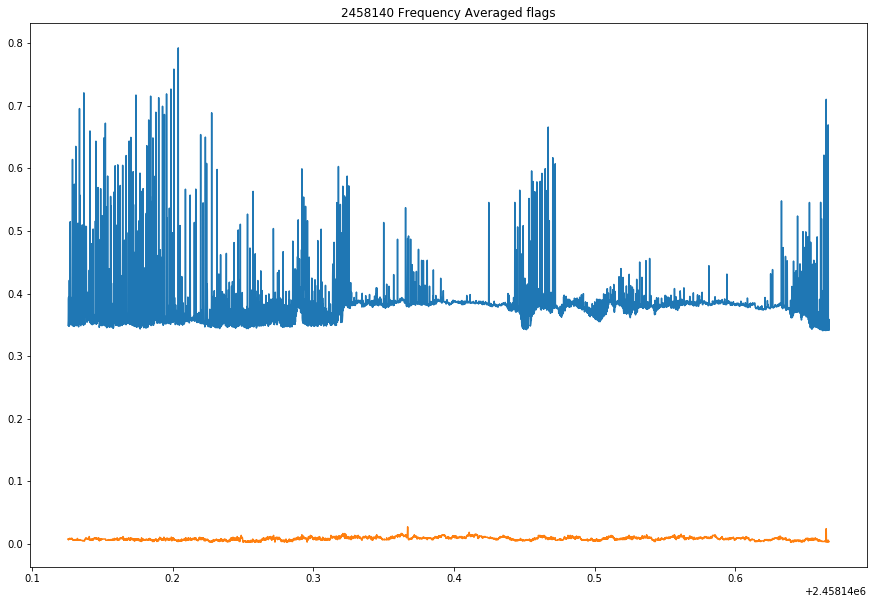

In [21]:
plt.figure(figsize=(15,10))
plt.title(str(directory) + ' Frequency Averaged flags')
plt.plot(flag_times_xx,chan_mean_yy_old, label='Old (including xants)')
plt.plot(flag_times_xx, chan_mean_yy, label='New (minus xants)')

# plt.ylim(-0.1,1.1)
plt.show()


In [ ]:
print xants_xx
# print xants_yy

In [ ]:
print basesum

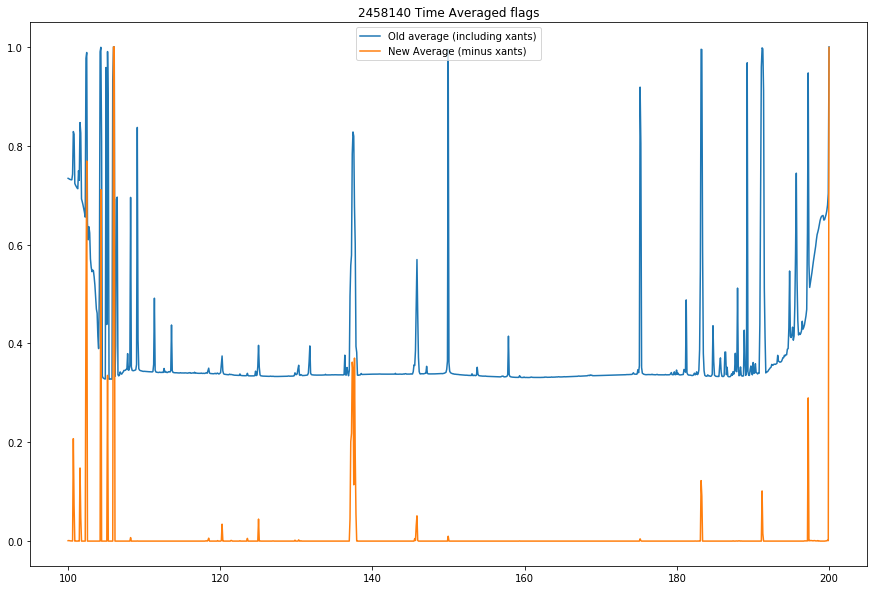

In [22]:

freqs=np.linspace(100, 200, num=1024)
plt.figure(figsize=(15,10))
plt.title(str(directory) + ' Time Averaged flags')
plt.plot(freqs,time_mean_yy_old, label='Old average (including xants)')
plt.plot(freqs,time_mean_yy, label='New Average (minus xants)')
plt.legend()
# plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
numants=5
numxants=2
numbaselines=(numants*(numants+1))/2
numxbase=(numxants*(numxants+1))/2
testsum=0
a=np.linspace(1, 10,10, endpoint=True)

goodbase=((numants-numxants)*(numants-numxants +1))/2
print testsum
print goodbase
print numbaselines
print numxbase
print numbaselines-goodbase

In [ ]:
antcomb=it.combinations_with_replacement(np.linspace(1, numants,numants, endpoint=True), 2)
noxantcomb=it.combinations_with_replacement(np.linspace(1, numants-numxants,numants-numxants, endpoint=True), 2)
baselines=list(antcomb)
goodbaselines=list(noxantcomb)
numbaselines=len(baselines)
numgoodbaselines=len(goodbaselines)
numbadbaselines=numbaselines-numgoodbaselines
print numbaselines
print numgoodbaselines
print numbadbaselines

In [ ]:
a=[[0],[0],[0],[1],[0],[1],[1],[0],[1],[1],[1],[0],[1],[1],[1],[0],[1],[1],[1],[0],[1],[0],[1],[0],[1],[1],[0],[0],[0],[1]]
b=np.asarray(a)
c=np.reshape(b, (3,10,1))
d=np.sum(c, axis=1)-1
e=d/(10.0-1.0)
print b
print c
print d
print e

In [ ]:
'''
To Do:
======
[*]plot single JD normally, then without flagged antennas
[*]fix equation for flag antennas to include ALL xant baselines (not just xants/xants)
    [*]Get Nants
[ ]
'''